In [259]:
import compute_convergence
import data
import glob
import seaborn as sns
import numpy as np
import pandas as pd
import re

sns.set_theme()

# Data of experiments

In [301]:
biased = data.load_data("../output/biased/synthetic/s12/", "random_*")
#hybrid = data.load_data("../output/hybrid/synthetic/s12/", "random_*")
#newepxp= data.load_data("../output/hybrid/synthetic/s12b/", "random_*")
newepxp= data.load_data("../output/hybrid/synthetic/s12c/", "random_*")
#biased = data.postprocess(biased)
hybrid = newepxp

In [302]:
hybrid.shape

(553, 625)

## Prepare the hybrid dataset

In [303]:
hybrid['lp'] = hybrid.file.str.split('/').str[-1].str.split('_').str[-3] == 'lptrue'
hybrid['tps'] = hybrid.file.str.split('/').str[-1].str.split('_').str[-2].str[3:].astype(int)

#newepxp['lp'] = newepxp.file.str.split('/').str[-1].str.split('_').str[-3] == 'lptrue'

In [304]:
cols = [ n for n in hybrid.columns if not re.fullmatch('.*_[0-9]*',n) ]

In [305]:
dta = hybrid.copy()
print(dta.shape)
#dta['ll'] = dta.apply(lambda row: row[[f"llk_{i}" for i in range(300)]].values, axis=1)
dta["pns"]= dta.apply(lambda row: row[[f"pns_{i}" for i in range(300)]].values, axis=1)
dta["iter"]= dta.apply(lambda row: row[[f"iter_{i}" for i in range(300)]].values, axis=1)
dta['pns_l'] = dta.pns.apply(min)
dta['pns_u'] = dta.pns.apply(max)
dta = dta[np.abs(dta.pns_l - dta.pns_u) > 0.02]
outdata_hybrid=dta[['pns', "iter", "pns_l", "pns_u", 'file', "model_type",'lp']]
hybrid.model_type.unique()

(553, 627)


array(['Dx+Dzb ', 'Dzb ', 'Dx', 'Dobs ', 'Dobs+Dx', 'Dobs+Dzb ',
       'Dobs+Dx+Dzb '], dtype=object)

# Compute Intevals for different experiments (Hybrid)

Index the file and pivot on the model_type, showing the values of the pns as output, no aggregation is needed as there is only one file-model_type pair

In [307]:
condition = outdata_hybrid.lp
dta = outdata_hybrid[condition].pivot_table(values=["pns_l", "pns_u"], index="file", columns="model_type")
dta.columns = ["_".join(c) for c in dta.columns]
dta.to_csv("hybrid_6_LPTrue.csv")

condition = ~outdata_hybrid.lp
dta = outdata_hybrid[condition].pivot_table(values=["pns_l", "pns_u"], index="file", columns="model_type")
dta.columns = ["_".join(c) for c in dta.columns]
dta.to_csv("hybrid_6_LPFalse.csv")


# NAs

## Count dominating cases

Count the number of experiments where the lower pns of some model_type is >, < or == to another

In [308]:
# count rows > columns
def process(pnsl, pnsu, order):
    pns_data = pnsl
    pnsl_df_gt = pd.DataFrame(
        [ [ sum(pns_data[r] > pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    pns_data = pnsl
    pnsl_df_lt = pd.DataFrame(
        [ [ sum(pns_data[r] < pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    pns_data = pnsl
    pnsl_df_eq = pd.DataFrame(
        [ [ sum(pns_data[r] == pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    pns_data = pnsu
    pnsu_df_gt = pd.DataFrame(
        [ [ sum(pns_data[r] > pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    pns_data = pnsu
    pnsu_df_lt = pd.DataFrame(
        [ [ sum(pns_data[r] < pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    pns_data = pnsu
    pnsu_df_eq = pd.DataFrame(
        [ [ sum(pns_data[r] == pns_data[c]) for c in pns_data.columns ] for r in pns_data.columns], 
        columns=pns_data.columns, 
        index=pns_data.columns)

    # Overall
    cols = pnsu.columns
    containement = pd.DataFrame(
        [ [ sum((pnsl[r] >= pnsl[c]) & (pnsu[r] <= pnsu[c])) for c in cols ] for r in cols], 
        columns=cols, 
        index=cols)

    return containement[order].loc[order]



In [309]:
order = hybrid.model_type.unique()
condition = ~outdata_hybrid.lp
pnsl = outdata_hybrid[condition].pivot_table(values=["pns_l"], index="file", columns="model_type")["pns_l"]
pnsu = outdata_hybrid[condition].pivot_table(values=["pns_u"], index="file", columns="model_type")["pns_u"]
process(pnsl, pnsu, order)

model_type,Dx+Dzb,Dzb,Dx,Dobs,Dobs+Dx,Dobs+Dzb,Dobs+Dx+Dzb
model_type,,,,,,,
Dx+Dzb,32,19,7,2,3,2,2
Dzb,2,33,2,1,1,1,1
Dx,9,19,32,3,5,5,3
Dobs,4,20,3,30,1,6,6
Dobs+Dx,11,21,5,5,32,8,11
Dobs+Dzb,10,20,5,3,7,30,8
Dobs+Dx+Dzb,6,23,6,6,9,7,32


In [310]:
condition = outdata_hybrid.lp
pnsl = outdata_hybrid[condition].pivot_table(values=["pns_l"], index="file", columns="model_type")["pns_l"]
pnsu = outdata_hybrid[condition].pivot_table(values=["pns_u"], index="file", columns="model_type")["pns_u"]
process(pnsl, pnsu, order)



model_type,Dx+Dzb,Dzb,Dx,Dobs,Dobs+Dx,Dobs+Dzb,Dobs+Dx+Dzb
model_type,,,,,,,
Dx+Dzb,27,19,5,1,2,1,4
Dzb,1,30,1,1,0,1,1
Dx,10,17,27,1,2,5,6
Dobs,3,19,1,25,2,4,4
Dobs+Dx,6,20,9,5,27,8,9
Dobs+Dzb,4,20,4,5,5,25,4
Dobs+Dx+Dzb,4,18,3,4,2,2,26


# Biased Data


## Prepare the biased dataset

In [11]:
dta = biased.copy()
cols = [ n for n in biased.columns if not re.fullmatch('.*_[0-9]*',n) ]

dta['ll'] = dta.apply(lambda row: row[[f"llk_{i}" for i in range(300)]].values, axis=1)
dta["pns"]= dta.apply(lambda row: row[[f"pns_{i}" for i in range(300)]].values, axis=1)
dta["sizes"]= dta.apply(lambda row: row[[f"trajectory_size_{i}" for i in range(300)]].values, axis=1)

dta['pnsok'] = dta.apply(lambda xx : xx.pns[np.abs(xx.ll.astype(float) - xx.ll_max) < 0.01], axis=1)
#dta = dta[dta.pnsok.apply(len) > 2]
dta.pns_l = dta.pns.apply(min)
dta.pns_u = dta.pns.apply(max)

dta = dta[np.abs(dta.pns_l - dta.pns_u) > 0.02]
outdata_biased=dta[np.concatenate([['pns', 'pnsok', 'll', 'sizes'], cols])]

In [12]:
dta.shape

(1806, 928)

In [13]:
a = [ ]
for col in biased.columns:
    match = re.fullmatch("pns_([0-9]*)", col)
    if match:
        a.append(int(match[1]))
len(a)

300

In [14]:
def rrmse(a,b,astar,bstar):
    return np.sqrt(((a - astar) ** 2 + (b - bstar) ** 2) / (2 * (bstar - astar)**2))



def rrmse_upper(a,b,astar,bstar, eps = 0.00000001):
    bstar1 = (1-bstar)

    if bstar < 1-eps:
        return np.abs(((bstar-b) / (1 - bstar)))
    return 0
    

def rrmse_lower(a,b,astar,bstar, eps = 0.00000001):
    if astar > eps:
        return np.abs(((a - astar) / astar))
    return 0


def rrmse_average(a,b,astar,bstar, eps = 0.00000001):
    bstar1 = (1-bstar)
    sum = 0
    count = 0

    if astar > eps:
        sum += ((a - astar) / astar)**2
        count += 1
    if bstar < 1-eps:
        sum += ((bstar-b) / (1 - bstar))**2 
        count += 1
    
    if count == 0: return 0
    return np.sqrt(sum / count)

def rrmse2(a,b,astar,bstar):
    bstar1 = (1-bstar)
    sum = 0
    div = 0
    if astar > 0:
        sum += np.sqrt(
            (
                (a - astar) ** 2
            ) / 
            (astar**2)
        ) * astar 
        div += astar

    if bstar < 1:
        sum += np.sqrt(
            (
                (b - bstar) ** 2
            ) / 
            (1 - bstar)**2
        ) * bstar1
        div += bstar1

    if div == 0: return 0
    return sum / div

In [15]:
from ipywidgets import interact, FloatSlider
from ipywidgets.widgets import Dropdown
import seaborn as sns
import matplotlib.pyplot as plt

@interact(
        apercent=FloatSlider(min=0,max=1),
        bpercent=FloatSlider(min=0,max=1), 
        astar =FloatSlider(0.25,min=0,max=1, step=0.01), 
        bstar=FloatSlider(0.75, min=0,max=1, step=0.01), 
        error = Dropdown(options=[("RRMSE",rrmse), ("Proposal 1",rrmse2), ("Average",rrmse_average)])
)
def show(apercent,bpercent,astar,bstar, error):
    points = 100
    a = apercent * astar
    b = bstar + (1 - bpercent) * (1-bstar)
    score = error(a,b, astar, bstar)
    data = [[error(ap, bp, astar, bstar) if (ap <= astar) and (bp >= bstar) else 0 for ap in np.linspace(0,1,points) ] for bp in np.linspace(0,1,points)]

    data = pd.DataFrame(data, columns=np.linspace(0,1,points), index=np.linspace(0,1,points))
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sns.heatmap(data, ax=ax, vmax=1, cmap=sns.light_palette("seagreen", as_cmap=True))


    
    

interactive(children=(FloatSlider(value=0.0, description='apercent', max=1.0), FloatSlider(value=0.0, descript…

In [17]:
reference = outdata_biased[outdata_biased.ps1 == 1].groupby("file").max("index").reset_index()[['file', 'pns_l', 'pns_u']].rename({"pns_l":"astar", "pns_u":"bstar"}, axis=1)

merged = outdata_biased.merge(reference, on='file', how="inner")
merged['rrmse_avg'] = merged.apply(lambda row: rrmse_average(row.pns_l, row.pns_u, row.astar, row.bstar), axis=1)
merged['rrmse'] = merged.apply(lambda row: rrmse(row.pns_l, row.pns_u, row.astar, row.bstar), axis=1)
merged['rrmse2'] = merged.apply(lambda row: rrmse2(row.pns_l, row.pns_u, row.astar, row.bstar), axis=1)
merged['rae_upper'] = merged.apply(lambda row: rrmse_upper(row.pns_l, row.pns_u, row.astar, row.bstar), axis=1)
merged['rae_lower'] = merged.apply(lambda row: rrmse_lower(row.pns_l, row.pns_u, row.astar, row.bstar), axis=1)


In [147]:
da,db,das,dbs =  merged.iloc[merged.rrmse_avg.argmax()][['pns_l', 'pns_u', "astar", "bstar"]]

r = rrmse_average(da,db,das,dbs) 
print(da,db,das,dbs, r)

0.0016989676858184 0.8601987261191107 5.746841981453309e-08 0.09976 20903.844924169276


In [18]:
bins = 5
intervals = np.linspace(0,1,bins)
interval_index = pd.IntervalIndex.from_arrays(np.concatenate(([-1], intervals[0:bins-1])), intervals[0:bins])
merged['discretized'] = pd.cut(merged[merged.ps1 < 1].ps1, bins=interval_index)


In [19]:
merged["Average"] = (merged.rae_lower + merged.rae_upper) / 2
merged[(merged.ps1 >0.00)].shape

(1447, 37)

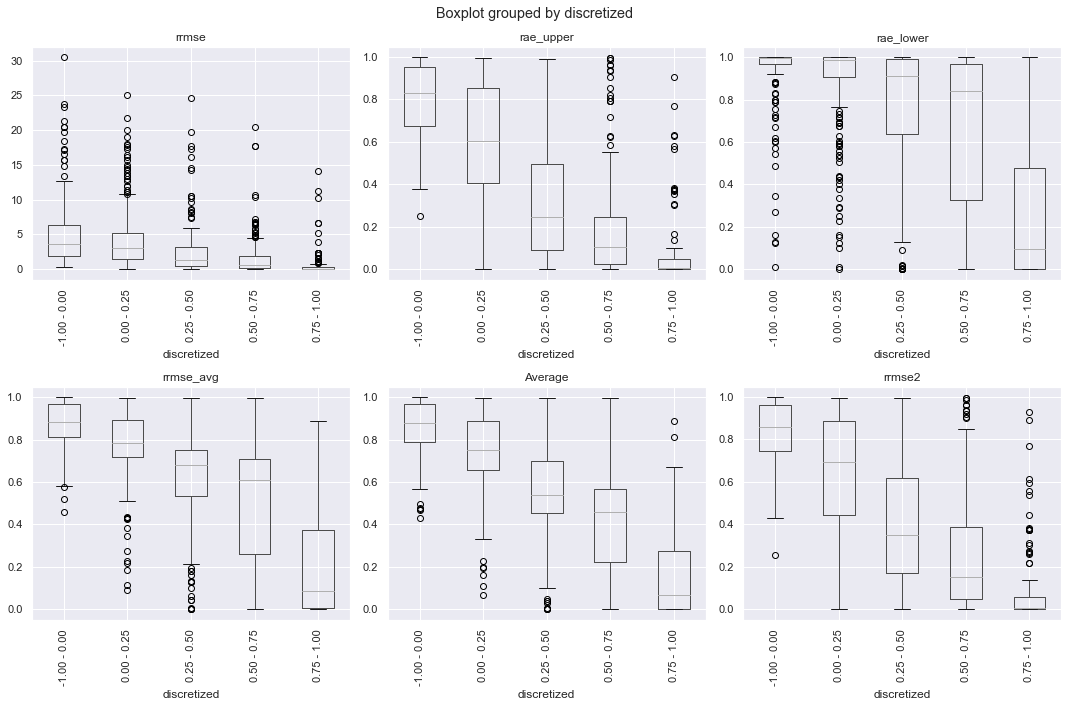

In [20]:
from ipywidgets.widgets import Dropdown
#@interact(filtering=Dropdown(options=[('No filter',0),('Separate',1),('Agressive',2)]))
def plot(filtering=1):
    import matplotlib.pyplot as plt
    cols = [(0,0,"rrmse", "all"), (0,1,"rae_upper", "upper"), (0,2,"rae_lower", "lower"), (1,0,"rrmse_avg", "all"), (1,1,"Average", "all"), (1,2,"rrmse2", "all")]
    
    fig, axs = plt.subplots(2, 3, figsize=(15,10))

    notpns1 = merged[(merged.ps1 != 1)]
    values = merged[(merged.ps1 != 1) & (merged.pns_l <= merged.astar) & (merged.pns_u >= merged.bstar)]
    
    if filtering == 0:
        values = notpns1
        values_lower = values
        values_upper = values
    elif filtering == 1:
        values_lower = values
        values_upper = values
    else :
        values_lower = merged[(merged.ps1 != 1) & (merged.pns_l <= merged.astar)]
        values_upper = merged[(merged.ps1 != 1) & (merged.pns_u >= merged.bstar)]
    
    for x,y,col, data in cols:
        if data == "all":
            vals = values
        elif data == "lower":
            vals = values_lower
        elif data == "upper":
            vals = values_upper
        
        boxplot = vals[[col, "discretized"]].boxplot(column=col, ax=axs[x,y],  rot=90, by="discretized", return_type="dict")

        dl = [disc.left for disc in values.discretized.dtype.categories.values]
        dr = [disc.right for disc in values.discretized.dtype.categories.values]

        axs[x,y].get_xaxis().set_ticklabels([f"{l:.2f} - {h:.2f}" for l,h in zip(dl, dr)])
        l = [ low.get_ydata()[1] for low in boxplot[col]["whiskers"][::2] ]
        h = [ high.get_ydata()[1] for high in boxplot[col]["whiskers"][1::2] ]
        m = [ med.get_ydata()[0] for med in boxplot[col]["medians"]]
        q1 = [ box.get_ydata()[0] for box in boxplot[col]["boxes"]]
        q3 = [ box.get_ydata()[3] for box in boxplot[col]["boxes"]]
        fliers = [ ",".join([str(i) for i in fl.get_ydata()]) for fl in boxplot[col]["fliers"]]

        plots = pd.DataFrame({"PS1_l": dl, "PS1_u": dr, "min":l, "max":h, "q1":q1, "q3":q3, "median":m, "fliers":fliers})
        #plots.to_csv("lower.csv", index=None)

    plt.tight_layout()

plot(1)

# Coverage testing

compute probability that our 300 runs are withing an epsilon expansion of the bounds

## Hybrid data

In [41]:
outdata_hybrid.shape

(491, 7)

In [311]:
import convergence
from functools import partial


for eps in [0.01,0.05, 0.1]:        
    f = partial(convergence.p_eps_convergence, eps=eps, eps2=0.001, abs=1e-8, rel=1e-8)
    c = lambda t : t.astype(float)
    output = outdata_hybrid.pns.apply(c).apply(f)
    data = pd.DataFrame(output.values.tolist(), columns=["P", "num", "den", 'enum', 'eden', 'alpha', 'beta', 'bound'], index = outdata_hybrid.index)
    for col in data.columns:
        outdata_hybrid[f'{col}_{eps}'] = data[col]


/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [312]:

def boxplot(data):
    data = np.array(data)
    q1, q2, q3 = np.quantile(data, [0.25, 0.5, 0.75])
    iqr = q3 - q1
    low = np.min(data[data > q1 - 1.5 * iqr])
    high = np.max(data[data < q3 + 1.5 * iqr])

    w1 = ",".join([str(v) for v in data[data<low]])
    w2 = ",".join([str(v) for v in data[data>high]])
    return  low, q1, q2, q3, high, w1, w2


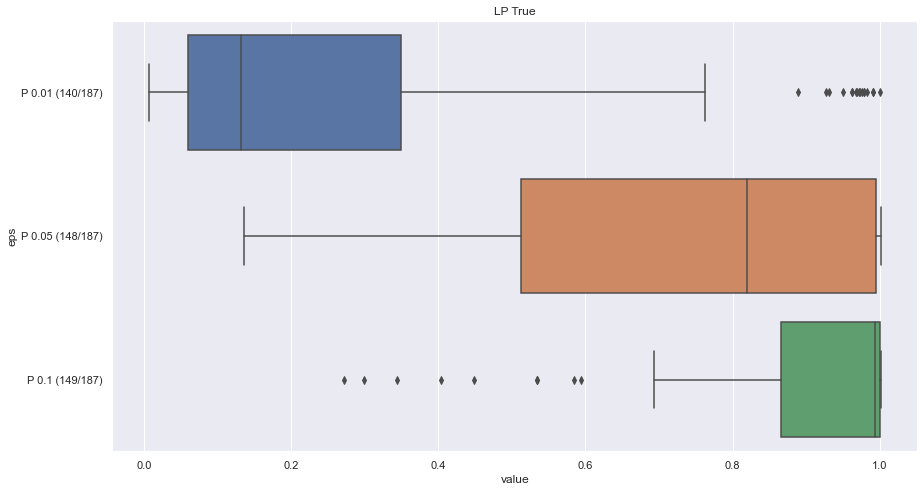

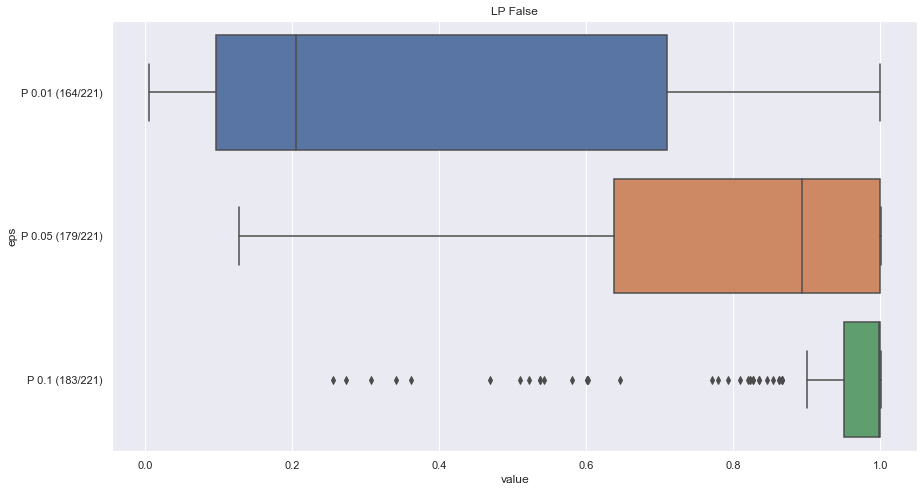

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt


for lp in [True, False]:
    fig, axs = plt.subplots(1,1,figsize=(13,7))
    ax = axs #[int(lp)]
    dta = pd.DataFrame(columns=['eps',"value"])
    for eps in [0.01,0.05, 0.1]:
        sfull = p = outdata_hybrid[(outdata_hybrid.lp == lp)].shape[0]
        p = outdata_hybrid[
            (outdata_hybrid.lp == lp) & 
            (outdata_hybrid[f'enum_{eps}'] <  outdata_hybrid[f'num_{eps}']) & 
            (outdata_hybrid[f'eden_{eps}'] <  outdata_hybrid[f'den_{eps}'])
        ][f'P_{eps}']
        #dta[f"P_{eps}"]=p.values
        size = p.shape[0]
        dta = pd.concat((dta, pd.DataFrame({"value":p, "eps":f"P {eps} ({size}/{sfull})"})))
                    
    sns.boxplot(data=dta, x='value', y="eps", ax=ax, )
    ax.set_title(f"LP {lp}")
    plt.tight_layout()


    def assign(row):
        row['low'],row['q1'],row['median'],row['q3'],row['high'],row['w1'],row['w2'] = row['value'] 
        return row[[ "low", "q1", 'median', 'q3', 'high', 'w1', 'w2']]

    dta.groupby("eps").agg(boxplot).apply(assign, axis=1).to_csv(f"P_convergence_hybrid_lp{lp}.csv")

## Biased data

In [238]:
def fun(data):
    f = partial(convergence.p_eps_convergence, eps=eps, eps2=0.0001, abs=1e-8, rel=1e-8)
    try:
        return f(data)
    except Exception as e:
        return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, "Ex"]

for eps in [0.01,0.05, 0.1]:        
    c = lambda t : t.astype(float)
    output = merged.pns.apply(c).apply(fun)
    data = pd.DataFrame(output.values.tolist(), columns=["P", "num", "den", 'enum', 'eden', 'alpha', 'beta', 'bound'], index = merged.index)
    for col in data.columns:
        merged[f'{col}_{eps}'] = data[col]

/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/dhuber/Development/credici/papers/journalPGM/postprocess/convergence.py:70: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  num, e1 = quad(f, 0, eps*L, epsabs=abs, epsrel=rel)
/Users/dhuber/Development/credici/papers/journalPGM/postprocess/convergence.py:75: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  den, e2 = quad(f, 0, 1 - b, epsabs=abs, epsrel=rel)
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/dhuber/Development/credici/papers/journalPGM/postprocess/convergence.py

In [246]:
dta = pd.DataFrame(columns=['eps',"value"])
for eps in [0.01,0.05, 0.1]:
    sfull = merged.shape[0]
    p = merged[
        (merged[f'enum_{eps}'] <  merged[f'num_{eps}']) & 
        (merged[f'eden_{eps}'] <  merged[f'den_{eps}'])
    ][f'P_{eps}']
    d= merged[
        (merged[f'enum_{eps}'] <  merged[f'num_{eps}']) & 
        (merged[f'eden_{eps}'] <  merged[f'den_{eps}'])
    ][f'discretized']
    #dta[f"P_{eps}"]=p.values
    size = p.shape[0]
    dta = pd.concat((dta, pd.DataFrame({"value":p, 'discretized':d, "eps":f"P {eps} ({size}/{sfull})"})))
                


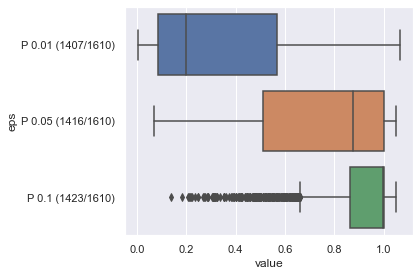

In [248]:
sns.boxplot(data=dta, x='value', y="eps",  )
plt.tight_layout()
plt

def assign(row):
    row['low'],row['q1'],row['median'],row['q3'],row['high'],row['w1'],row['w2'] = row['value'] 
    return row[[ "low", "q1", 'median', 'q3', 'high', 'w1', 'w2']]

dta[['eps','value']].groupby("eps").agg(boxplot).apply(assign, axis=1).to_csv(f"P_convergence_merged.csv")

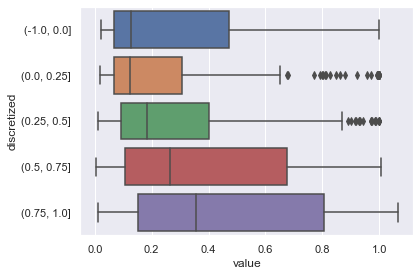

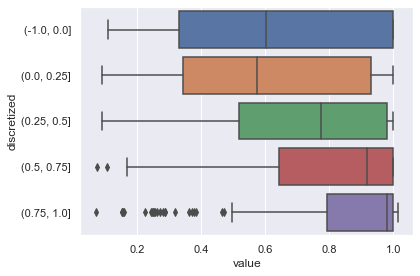

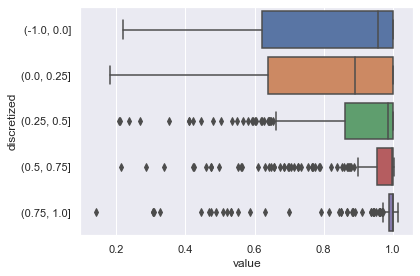

In [256]:
for eps in dta.eps.unique():
    fix, ax = plt.subplots(1,1)
    sns.boxplot(data=dta[dta.eps == eps], x='value', y='discretized', ax = ax )
    plt.tight_layout()